# Final Project (Due: 4/29/2024 at 4:00 sharp - start of the final exam)

### Name: Minati Alphonso
### Course Level: 761

### You are NOT allowed to use models/tools from the scikit-learn toolbox.  Similar to other projects, you are free to use anything we've discussed in class, code from your other projects, etc. 

**Introduction:**
* In this project, we explore the wonderful world of natural language processing (NLP) and sentiment analysis.  As noted in class, this will a a **bakeoff** competition!  However, in the interest of grading, the bakeoff portion will only account for 15% of your grade.  The remaining portions of the grade will be determined from:

1. Your model complexity.
2. Your code style and correctness.
3. Your write-up (this document), evalaution instructions, and presentation (for 5xx/7xx students)

**Objectives:**
* The objective of this project is to develop a classifier for sentiment analysis.  As with all other projects, the level of dificulty increases depending on the level you are in the course.

* You should familiarize yourself with the dataset by visiting the [Kaggle Site](https://www.kaggle.com/datasets/bhavikjikadara/emotions-dataset)

## All Students

* The analysis of this project will be slightly different than the analysis of previous projects in several ways:

1. You will be given a training set (labeled data) to build your model (similar to before) where you'll want to do some cross-validation to ensure your model generalizes well.
2. You will be given a separate "test" set, however, the test set will NOT contain labels (this is to ensure you do NOT use the test set for training your model - common in competitions).
3. You will use your model to generate a set of predictions and write them to file (**EXACTLY**) like the file "emotion_prediction_example.csv" in D2L (this format must be followed exactly or your predicitons will be off - and you'll lose points)
    - This is how Jackson will "score" the classifier (he has the correct predictions, so he'll compare them with your model predictions for accuracy)
4. Project writeup/presentation.

## Graduate Students Only

* For the graduate students, you will be given the raw data (we've trimmed it so you shouldn't need an HPC to store the data).  You will need to:

1. Determine how you want to encode the data from words/sentences to feature space (there are multiple methods to accomplish this task)
    - You may use some built-in functions to accomplish this, but only for the generation of features.
2. Do some exploritory data analysis to see how the data is distributed and develop some meaningful visualizations.
3. Determine how you want to design a test/train set for validation of your model.
4. Determine what model you want to use (can be a collection of models for an ensemble if you want), and justify why you like this model.
5. Build the model and do the model validation (present the validation results).
6. Evaluate your model on the test set (provided) and create your predictions for the bakeoff portion.
7. Submit:
    - Your writeup with sufficient detail (both in code AND markdown) to understand what you've done, why, and what your results illustrate (this should be in a table illustrating aaccuracy for each fold)
    - Your .csv of predictions for the bakeoff.

* **Note:** Graduate students will work solo on this project and design a presentation (no more than 10 minutes with a couple minutes for questions).  You will present your EDA, model development, and results to the class during the normal final exam schedule 4/29/2024 at 4:00 MST)



### Quick Overview
#### Model used: RandomForest Classifier
#### Encoder used: Term Frequency Inverse Document Frequency (TF-IDF)

In [1]:
# Code here #
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import re

#### Function to preprocess text data: remove non-alphabetic characters and convert to lowercase

In [2]:
def preprocess_text(X):
    processed_texts = []
    for text in X:
        # remove non-alphabet and turn to lowercase
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
        processed_texts.append(cleaned_text)

    return np.array(processed_texts)

#### Function to build vocabulary and calculate document frequency for terms in the documents

To be able to successfully calculate the TDIDF matrix, I need to find a way to reduce the vocabulary a bit. I understand that in doing so, I might be missing an important word, but this was the best way I could think of. I am essentially keeping words that appear in atleast 1/8 of a per cent (or 0.0025) of all the documents.

In [3]:
def build_vocabulary_and_doc_freq(doc_list, stopwords, min_doc_percentage=0.0025):
    min_doc_freq = int(len(doc_list) * min_doc_percentage)
    
    doc_freq = Counter() # how many documents contain the term
    
    for doc in doc_list:
        unique_terms = set(doc.split())
        doc_freq.update(unique_terms) # count each term once per document
    
    
    vocabulary = {term: idx for idx, term in 
                  enumerate(term for term in sorted(doc_freq) 
                            if doc_freq[term] >= min_doc_freq 
                            and term not in stopwords)}
    
    return vocabulary, doc_freq

#### Calculate TF-IDF values for a list of documents (rows in X)
- TF-IDF: evaluates the importance of a word to a document in a collection.
- TF or term frequency: measures how frequently a term occurs in a document.
- IDF or Inverse Document Frequency: measures how important a term is within the entire list of documents

I had a lot of space related issues with this. I ended up having to reduce the vocabulary a bit and also calculate document frequency alongside the vocabulary inorder to get rid of multiple loops. Document in this context refers to every row in the dataset.

In [4]:
# TF-IDF or Term Frequency-Inverse Document Frequency
# TF = # times the term appears in the document / # terms in the document
# IDF = log(# documents / # documents with term 't')
# TF_IDF = TF*IDF
def calc_tfidf(doc_list, vocabulary, doc_freq, num_docs):
    num_terms = len(vocabulary)
    
    # initialize a dense matrix
    tfidf_matrix = np.zeros((num_docs, num_terms), dtype=np.float32)
    
    idf_values = {term: np.log((num_docs+1)/(doc_freq[term]+1)) for term in vocabulary}
    
    for doc_idx, doc in enumerate(doc_list):
        terms = doc.split()
        doc_length = len(terms)
        term_freq = Counter(terms)
        for term, freq in term_freq.items():
            if term in vocabulary:
                tf = freq / doc_length
                idf = idf_values[term]
                tfidf_matrix[doc_idx, vocabulary[term]] = tf * idf
    
    return tfidf_matrix

#### Classes for implementing decision tree and random forest model

These functions are based on what was done in the previous project. The most notable difference is that I am looking at only the non-zero entries for every feature when finding the best split. This saves a lot of time as the TFIDF matrix tends to have many zero values which are not helpful. Additionally, I am also generating thresholds at different percentiles, this greatly helps with the time to run this. 

In [5]:
# Function to determine the most common class label
def calculate_mode(y):
    return np.argmax(np.bincount(y))

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index # index of feature used for splitting
        self.threshold = threshold # threshold value at split
        self.left = left
        self.right = right
        self.value = value # class value if this is leaf node

class DecisionTree:
    def __init__(self, max_depth, min_samples, default_label):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.default_label = default_label
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)
    
    def predict(self, X):
        return [self._dt_predict(x_sample, self.tree) for x_sample in X]
    
    def _dt_predict(self, x_sample, node):
        if node.value is not None:
            return node.value
        elif x_sample[node.feature_index] < node.threshold:
            return self._dt_predict(x_sample, node.left)
        else:
            return self._dt_predict(x_sample, node.right)
    
    def _build_tree(self, X, y, depth):
        if len(y) < self.min_samples or depth >= self.max_depth:
            common_label = calculate_mode(y)
            #print(f"Leaf: depth {depth}, label {common_label}.")
            return Node(value=common_label)
        
        # find best split
        best_feature, best_threshold = self._find_best_split(X, y)
        
        if best_feature is None:
            common_label = calculate_mode(y)
            #print(f"No valid split. Leaf at depth {depth} with label {common_label}.")
            return Node(value=common_label)
        
        # split dataset
        left_indices = X[:,best_feature] < best_threshold
        right_indices = X[:,best_feature] >= best_threshold
        
        # handle case where one side is empty
        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            common_label = calculate_mode(y)
            #print(f"No valid split. Leaf at depth {depth} with label {common_label}.")
            return Node(value=common_label)
        
        #print(f"Split at depth {depth} on feature {best_feature}.")
        left = self._build_tree(X[left_indices], y[left_indices], depth+1)
        right = self._build_tree(X[right_indices], y[right_indices], depth+1)
        
        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)
    
    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples <= 1:
            return None, None
        
        best_feature = None
        best_threshold = None
        best_ig = -np.inf
        
        # calculate entropy once for entire dataset
        parent_entropy = self._entropy(y)
        
        print_interval = n_features//10
        # iterate through each feature
        for feature_index in range(n_features):
            # get the non-zero entries for this feature
            nonzero_indices = X[:,feature_index].nonzero()[0]
            if len(nonzero_indices) <= 1:
                continue
            
            X_nonzero = X[nonzero_indices,feature_index].data
            y_nonzero = y[nonzero_indices]
            
            # generate thresholds at various percentiles
            thresholds = np.percentile(X_nonzero, np.linspace(10,90,9)) # percentiles from 10th to 90th
            # iterate over the thresholds
            for threshold in thresholds:
                ig = self._ig(X_nonzero, y_nonzero, threshold, parent_entropy)
                
                if ig > best_ig:
                    best_ig = ig
                    best_threshold = threshold
                    best_feature = feature_index
        
        return best_feature, best_threshold
    
    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts/counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _c_entropy(self, X, y, threshold):
        left_indices = X < threshold
        right_indices = X >= threshold
        
        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])

        left_weight = np.sum(left_indices)/len(y)
        right_weight = np.sum(right_indices)/len(y)

        c_entropy = (left_weight * left_entropy) + (right_weight * right_entropy)
        return c_entropy

    def _ig(self, X, y, threshold, parent_entropy):
        ig = parent_entropy - self._c_entropy(X, y, threshold)
        return ig

class RandomForestClassifier:
    def __init__(self, n_trees, max_depth, min_samples, n_samples, default_label):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.n_samples = n_samples
        self.default_label = default_label
        self.forest = []
        
    def fit(self, X, y):
        print("Training Trees...")
        for i in range(self.n_trees):
            print(f"Training tree {i+1} ...")
            sample_X, sample_y = self._bootstrap_sample(X, y, self.n_samples)
            tree = DecisionTree(self.max_depth, self.min_samples, self.default_label)
            tree.fit(sample_X, sample_y)
            self.forest.append(tree)
        print(f"{n_trees} trees trained.")
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.forest])
        predictions = predictions.T # (n_samples, n_trees)

        # majority vote
        final_predictions = np.array([calculate_mode(pred) for pred in predictions])

        return final_predictions
    
    def _bootstrap_sample(self, X, y, n_samples):
        indices = np.random.randint(0, X.shape[0], size=n_samples)
        return X[indices], y[indices]

#### Function to balance out the training dataset because of skewed distribution of classes.
I noticed that my models were very biased towards 1 given that it has a very high distribution. This function returns data in a way that keeps it having an even distribution of every label. It uses the class with smallest frequency to determine how many samples to keep in each class. 
I ended up removing this function since it did not help with my accuracy and my model was still always predicting class 1.

In [6]:
def under_sample(X, y):
    unique_labels, counts = np.unique(y, return_counts=True)
    n_samples = min(counts) # use smallest class to define the sampling rate
    
    indices_keep = []
    for label in unique_labels:
        indices = np.where(y == label)[0]
        if len(indices) > n_samples:
            sample_indices = np.random.choice(indices, size=n_samples, replace=False)
        else:
            sample_indices = indices
        indices_keep.extend(sample_indices)
    
    X_resampled = X[indices_keep]
    y_resampled = y[indices_keep]
    
    return X_resampled, y_resampled

#### Get the Training Dataset and separate into data and labels

In [7]:
# Train Data
raw_train_data = np.loadtxt("emotion_train_grad.csv",delimiter=",",dtype=str)
train_header = raw_train_data[:1]

train_data = raw_train_data[1:,0]
train_labels = raw_train_data[1:,1].astype(int)
print(f"train_data.shape: {train_data.shape}")
print(f"train_labels.shape: {train_labels.shape}")
print("train_labels distribution:\n",Counter(train_labels))

train_data.shape: (416809,)
train_labels.shape: (416809,)
train_labels distribution:
 Counter({1: 141067, 0: 121187, 3: 57317, 4: 47712, 2: 34554, 5: 14972})


#### Plot the label distribution of the training dataset

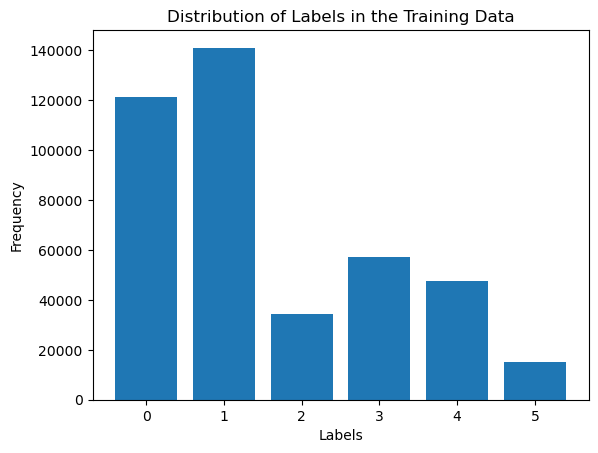

In [8]:
unique_train_labels, train_labels_count = np.unique(train_labels, return_counts=True)
plt.figure()
plt.bar(unique_train_labels, train_labels_count)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in the Training Data")
plt.xticks(unique_train_labels)
plt.show()

#### A list of stopwords

I did use the nltk toolkit to get this list. I have tried running my model without the stopwords too, but not much difference.

In [9]:
# import nltk
# from nltk.corpus import stopwords
# english_stopwords = stopwords.words('english')
# english_stopwords = [re.sub(r'[^a-zA-Z\s]', '', words).lower() for words in english_stopwords]
# print(english_stopwords)
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve',
             'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
             'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
             'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
             'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a',
             'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
             'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
             'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
             'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when',
             'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
             'very', 's', 't', 'can', 'will', 'just', 'don', 'dont', 'should', 'shouldve', 'now',
             'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'arent', 'couldn', 'couldnt',
             'didn', 'didnt', 'doesn', 'doesnt', 'hadn', 'hadnt', 'hasn', 'hasnt', 'haven',
             'havent', 'isn', 'isnt', 'ma', 'mightn', 'mightnt', 'mustn', 'mustnt', 'needn',
             'neednt', 'shan', 'shant', 'shouldn', 'shouldnt', 'wasn', 'wasnt', 'weren', 'werent',
             'won', 'wont', 'wouldn', 'wouldnt']

#### 5-fold Cross Validation

I am using the Random Forest classifier. I am splitting the training dataset into training and valdidation with a 80-20 split ratio and recording the accuracies for each fold. Before the loop starts, I first clean my text to make sure it is all in lowercase and only alphabets.

Accuracy for:
- Fold 1: 0.343
- Fold 2: 0.338
- Fold 3: 0.34
- Fold 4: 0.342
- Fold 5: 0.342

In [10]:
accuracies = []
train_data_processed = preprocess_text(train_data)
for i in range(5):
    num_observations = len(train_data_processed)

    # shuffle the data
    shuffled_indices = np.random.permutation(num_observations)
    train_data_shuffled = train_data_processed[shuffled_indices]
    train_labels_shuffled = train_labels[shuffled_indices]

    # calculate split index
    split_ratio = 0.80 # 80-20 split
    split_idx =  int(num_observations*split_ratio)

    # split the data
    X_train = train_data_shuffled[:split_idx]
    y_train = train_labels_shuffled[:split_idx]
    X_val = train_data_shuffled[split_idx:]
    y_val = train_labels_shuffled[split_idx:]
    
    # apply under-sampling to balance the training data
    #X_train, y_train = under_sample(X_train, y_train)
    #print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
    vocab, df = build_vocabulary_and_doc_freq(X_train, stopwords)
    tfidf_matrix_train = calc_tfidf(X_train, vocab, df, len(X_train))

    tfidf_matrix_val = calc_tfidf(X_val, vocab, df, len(X_val))
    
    default_label = calculate_mode(y_train)
    n_trees = 15
    max_depth = 10
    min_samples = 5
    n_samples = int(0.66 * tfidf_matrix_train.shape[0]) # 2/3

    model = RandomForestClassifier(n_trees, max_depth, min_samples, n_samples, default_label)
    model.fit(tfidf_matrix_train, y_train)
    
    val_predictions = model.predict(tfidf_matrix_val)
    val_accuracy = np.sum(val_predictions == y_val)/ len(y_val)
    accuracies.append(val_accuracy)
    print(f"Fold {i+1} accuracy: {val_accuracy:.3}")


Training Trees...
Training tree 1 ...
Training tree 2 ...
Training tree 3 ...
Training tree 4 ...
Training tree 5 ...
Training tree 6 ...
Training tree 7 ...
Training tree 8 ...
Training tree 9 ...
Training tree 10 ...
Training tree 11 ...
Training tree 12 ...
Training tree 13 ...
Training tree 14 ...
Training tree 15 ...
15 trees trained.
Fold 1 accuracy: 0.343
Training Trees...
Training tree 1 ...
Training tree 2 ...
Training tree 3 ...
Training tree 4 ...
Training tree 5 ...
Training tree 6 ...
Training tree 7 ...
Training tree 8 ...
Training tree 9 ...
Training tree 10 ...
Training tree 11 ...
Training tree 12 ...
Training tree 13 ...
Training tree 14 ...
Training tree 15 ...
15 trees trained.
Fold 2 accuracy: 0.338
Training Trees...
Training tree 1 ...
Training tree 2 ...
Training tree 3 ...
Training tree 4 ...
Training tree 5 ...
Training tree 6 ...
Training tree 7 ...
Training tree 8 ...
Training tree 9 ...
Training tree 10 ...
Training tree 11 ...
Training tree 12 ...
Training 

#### As you can see below, the accuracy is only around 34%. Really bad. I am guessing that whatever is correct is because the predicted 1 matched, given that my model seems to be always predicting 1s.

In [11]:
mean_accuracy = np.mean(accuracies)
std_deviation = np.std(accuracies)
print(f"Mean Accuracy: {mean_accuracy}, Standard Deviation: {std_deviation}")

Mean Accuracy: 0.34095871020369, Standard Deviation: 0.0018143694106302968


#### Now, I am retraining the model on the entire training dataset, followed by predicting on the test dataset

In [12]:
# Retrain on entire training dataset
vocabulary, doc_freq = build_vocabulary_and_doc_freq(train_data_processed, stopwords)
print(f"Vocabulary Size: {len(vocabulary)}")
tfidf_matrix_train = calc_tfidf(train_data_processed, vocabulary, doc_freq, len(train_data_processed))
print(f"tfidf_matrix_train.shape: {tfidf_matrix_train.shape}")

Vocabulary Size: 675
tfidf_matrix_train.shape: (416809, 675)


#### In the following code snippet, I am trying to get a feel of what the TFIDF matrix is doing and how it is assigning scores. As you can see in the output, 'overwhelmed' has the highest score which means it is more important. So that is a good sign.

In [28]:
doc_idx = 89
print(train_data_processed[doc_idx],"\n")

nonzero_indices = tfidf_matrix_train[doc_idx].nonzero()[0]
print("Indices: ",nonzero_indices)
index_to_word = {index: word for word, index in vocabulary.items()}
print("Words: ", [index_to_word.get(i) for i in nonzero_indices])
print("TFIDF scores: ", tfidf_matrix_train[doc_idx, nonzero_indices])

i was feeling really overwhelmed 

Indices:  [183 409 450]
Words:  ['feeling', 'overwhelmed', 'really']
TFIDF scores:  [0.23231736 0.95752233 0.5705573 ]


#### Plotting the top terms by their TFIDF scores
This doesn't look too good given that 'bit' has the highest score and most of these words are very neutral toned too.

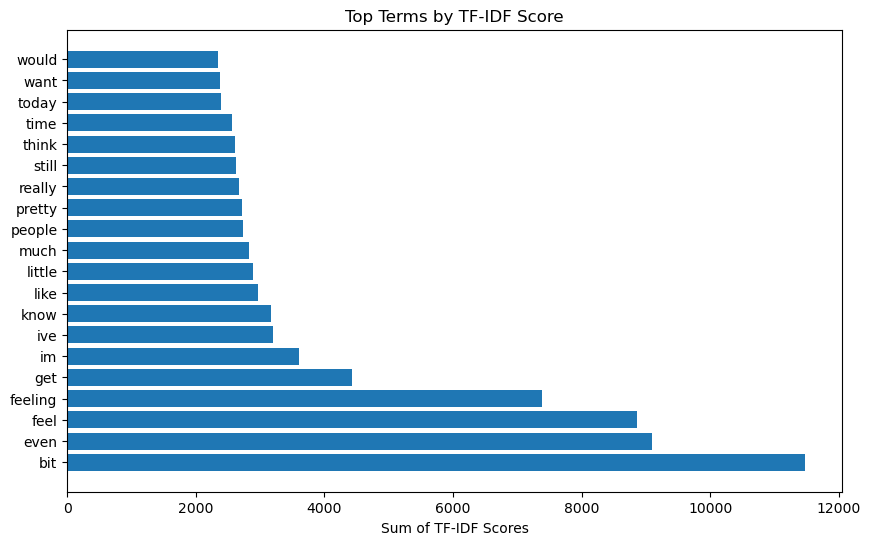

In [42]:
sum_tfidf = np.sum(tfidf_matrix_train, axis=0)  # Sum TF-IDF scores for each term across all documents
sorted_indices = np.argsort(sum_tfidf)[::-1]  # Sort indices by sum of TF-IDF scores

top_n = 20
top_terms = [term for term, idx in vocabulary.items() if idx in sorted_indices[:top_n]]
top_scores = sum_tfidf[sorted_indices[:top_n]]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_scores[top_n::-1])
plt.yticks(range(top_n), top_terms[top_n::-1])
plt.xlabel('Sum of TF-IDF Scores')
plt.title('Top Terms by TF-IDF Score')
plt.gca().invert_yaxis()
plt.show()

#### Plotting overall word frequency

These are the most common words across all the documents or rows of the dataset. I did notice that 'bit' is not in the top 20, but it does have the highest tfidf score.

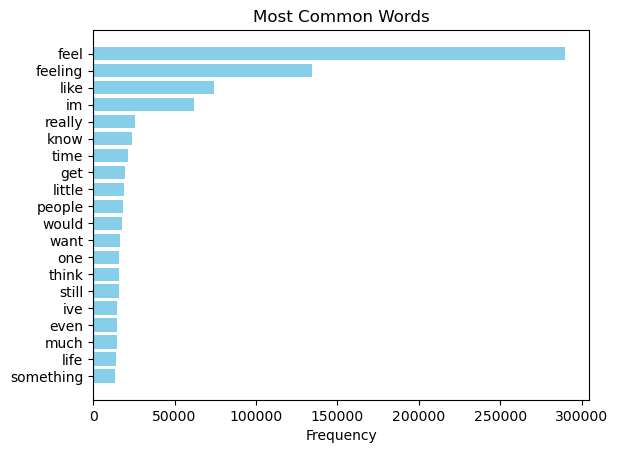

In [52]:
# overall word frequency
word_freq = Counter()
for row in train_data_processed:
    words = [word for word in row.split() if word not in stopwords]
    word_freq.update(words)

# plot 20 most common words
words, counts = zip(*word_freq.most_common(20))
plt.figure()
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Most Common Words')
plt.gca().invert_yaxis()
plt.show()

In [18]:
model_rf = RandomForestClassifier(n_trees=15, max_depth=10, min_samples=5, n_samples=int(0.66 *len(train_data_processed)), default_label=calculate_mode(train_labels))
model_rf.fit(tfidf_matrix_train, train_labels)

Training Trees...
Training tree 1 ...
Training tree 2 ...
Training tree 3 ...
Training tree 4 ...
Training tree 5 ...
Training tree 6 ...
Training tree 7 ...
Training tree 8 ...
Training tree 9 ...
Training tree 10 ...
Training tree 11 ...
Training tree 12 ...
Training tree 13 ...
Training tree 14 ...
Training tree 15 ...
15 trees trained.


In [19]:
# Test Data
raw_test_data = np.loadtxt("emotion_test_grad.csv",delimiter=",",dtype=str,encoding='utf-8')
test_header = raw_test_data[:1]

test_data = raw_test_data[1:,1]
print(f"test_data.shape: {test_data.shape}")

test_data.shape: (10613,)


In [20]:
# preprocess and vectorize test data
X_test_processed = preprocess_text(test_data)
tfidf_matrix_test = calc_tfidf(X_test_processed, vocabulary, doc_freq, len(X_test_processed))
print(f"tfidf_matrix_test.shape: {tfidf_matrix_test.shape}")

tfidf_matrix_test.shape: (10613, 675)


In [21]:
final_predictions = model_rf.predict(tfidf_matrix_test)

#### It has only predicted 1s. At this point is it even predicting?

In [23]:
print(f"Predictions: {np.bincount(final_predictions)}")

Predictions: [    1 10612]


#### Saving my 'predictions' to a file

In [56]:
import pandas as pd
ids = np.arange(0, len(final_predictions))
predictions_df = pd.DataFrame({
    'id': ids,
    'pred': final_predictions
})
predictions_df.to_csv('predictions_Minati_Alphonso.csv', index=False)

#### To replicate how the results were scored for the final, run the below code. This has been provided by the TA.

In [ ]:
# from sklearn.metrics import confusion_matrix
# pred_df = <YOUR PREDICTIONS DATAFRAME>

# test_df = pd.read_csv("emotion_test_final.csv")

# joined = pd.merge(test_df, pred_df, left_on="id", right_on="id", how="left")
# cm = confusion_matrix(joined["label"], joined["pred"])
# accuracy = cm.trace() / np.sum(cm)